<a href="https://colab.research.google.com/github/aasthadawar02/TME_6015/blob/main/Assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Libraries**

In [1]:
import numpy as np
import tensorflow as tf
from keras.layers import Input, Dense, Reshape, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

**Dataset Selection and Preprocessing**

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

**Auto-Encoder (AE) Implementation**

**Model Architecture**

In [4]:
input_img = Input(shape=(32, 32, 3))
x = Reshape((32*32*3,))(input_img)
x = Dense(32, activation='relu')(x)
encoded = Dense(16, activation='relu')(x)
x = Dense(32, activation='relu')(encoded)
x = Dense(32*32*3, activation='sigmoid')(x)
decoded = Reshape((32, 32, 3))(x)
autoencoder = Model(input_img, decoded)

In [5]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02), loss='mse')
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 reshape (Reshape)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 32)                98336     
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 32)                544       
                                                                 
 dense_3 (Dense)             (None, 3072)              101376    
                                                                 
 reshape_1 (Reshape)         (None, 32, 32, 3)         0     

**Training**

In [6]:
autoencoder.fit(x_train, x_train, validation_data=(x_test, x_test), epochs=20, batch_size=32)

Epoch 1/20
1563/1563 [==============================] - 13s 4ms/step - loss: 0.0450 - val_loss: 0.0438
Epoch 2/20
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0442 - val_loss: 0.0440
Epoch 3/20
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0442 - val_loss: 0.0441
Epoch 4/20
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0442 - val_loss: 0.0439
Epoch 5/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0442 - val_loss: 0.0439
Epoch 6/20
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0441 - val_loss: 0.0440
Epoch 7/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0441 - val_loss: 0.0439
Epoch 8/20
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0441 - val_loss: 0.0439
Epoch 9/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0441 - val_loss: 0.0441
Epoch 10/20
1563/1563 [==============================] - 7s 5ms/step - loss: 0.

In [7]:
def calculate_reconstruction_losses(original, reconstructed):
    mse_loss = tf.keras.losses.mean_squared_error(original.flatten(), reconstructed.flatten()).numpy()
    bce_loss = tf.keras.losses.binary_crossentropy(original.flatten(), reconstructed.flatten()).numpy()
    return mse_loss, bce_loss

In [8]:
x_pred = autoencoder.predict(x_test)

313/313 [==============================] - 1s 3ms/step


**Reconstruction**

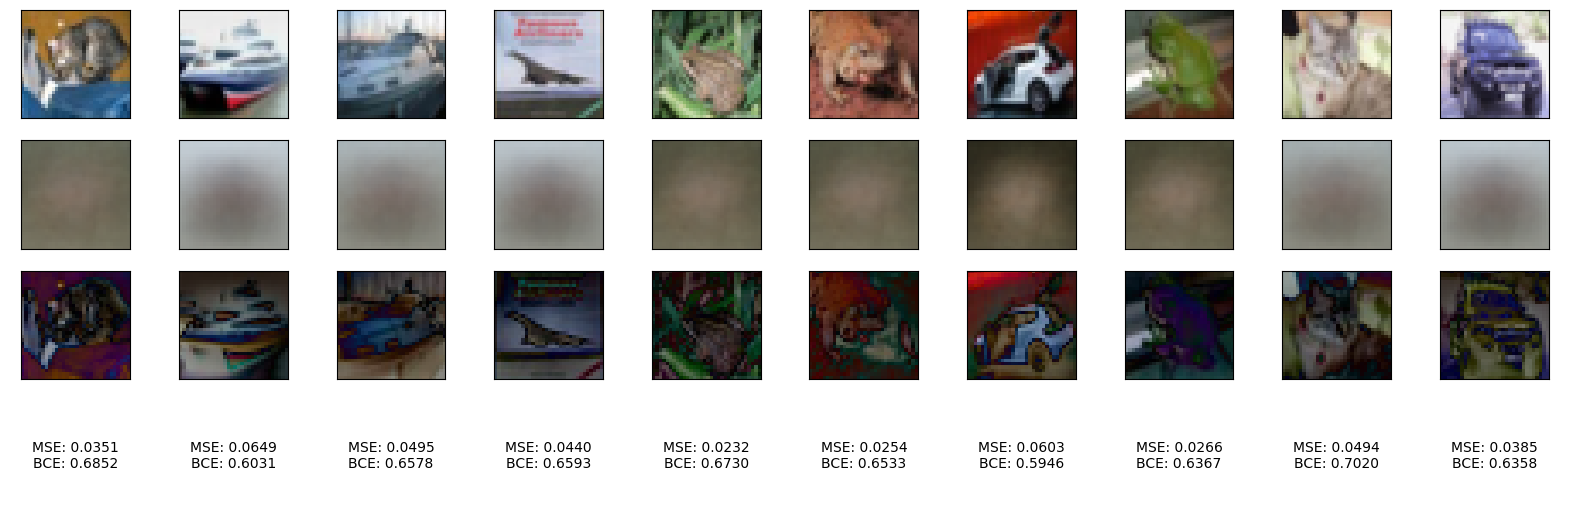

In [9]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 6 + 0.5))  # Adjust the figure size to accommodate three rows
for i in range(n):
    # Display original
    ax = plt.subplot(4, n, i + 1)
    original_img = x_test[i]
    plt.imshow(original_img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(4, n, i + 1 + n)
    reconstructed_img = x_pred[i]
    plt.imshow(reconstructed_img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display difference
    ax = plt.subplot(4, n, i + 1 + n * 2)
    difference = np.abs(original_img - reconstructed_img)
    plt.imshow(difference)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Calculate losses
    mse_loss, bce_loss = calculate_reconstruction_losses(original_img, reconstructed_img)

    # Add captions with losses
    ax = plt.subplot(4, n, i + 1 + n * 3)
    plt.axis('off')
    loss_caption = f"MSE: {mse_loss:.4f}\nBCE: {bce_loss:.4f}"
    plt.text(0.5, 0.5, loss_caption, ha='center', va='center', fontsize=10, transform=ax.transAxes)

plt.show()

**Hyperparameter Tuning**

In [10]:
learning_rates = [0.01, 0.02]
latent_dims = [8, 16]
best_loss = float('inf')
best_parameters = {}
for l_r in learning_rates:
  for latent_dim in latent_dims:
    input_img = Input(shape=(32, 32, 3))
    x = Reshape((32*32*3,))(input_img)
    x = Dense(32, activation='relu')(x)
    encoded = Dense(latent_dim, activation='relu')(x)
    x = Dense(32, activation='relu')(encoded)
    x = Dense(32*32*3, activation='sigmoid')(x)
    decoded = Reshape((32, 32, 3))(x)
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=l_r), loss='mse')
    autoencoder.fit(x_train, x_train, validation_data=(x_test, x_test), epochs=20, batch_size=64)
    test_loss = autoencoder.evaluate(x_test, x_test)
    if test_loss < best_loss:
      best_loss = test_loss
      best_parameters['learning_rate'], best_parameters['latent_space_dimension'] = l_r, latent_dim
    print("="*30)

print("Best Parameters: ", best_parameters)




Epoch 1/20
782/782 [==============================] - 6s 6ms/step - loss: 0.0453 - val_loss: 0.0441
Epoch 2/20
782/782 [==============================] - 4s 5ms/step - loss: 0.0440 - val_loss: 0.0437
Epoch 3/20
782/782 [==============================] - 4s 5ms/step - loss: 0.0445 - val_loss: 0.0440
Epoch 4/20
782/782 [==============================] - 3s 4ms/step - loss: 0.0440 - val_loss: 0.0437
Epoch 5/20
782/782 [==============================] - 4s 5ms/step - loss: 0.0440 - val_loss: 0.0438
Epoch 6/20
782/782 [==============================] - 4s 5ms/step - loss: 0.0440 - val_loss: 0.0439
Epoch 7/20
782/782 [==============================] - 4s 5ms/step - loss: 0.0439 - val_loss: 0.0436
Epoch 8/20
782/782 [==============================] - 4s 5ms/step - loss: 0.0438 - val_loss: 0.0435
Epoch 9/20
782/782 [==============================] - 4s 5ms/step - loss: 0.0438 - val_loss: 0.0436
Epoch 10/20
782/782 [==============================] - 4s 5ms/step - loss: 0.0438 - val_loss: 0.0434

In [11]:
l_r, latent_dim = best_parameters['learning_rate'], best_parameters['latent_space_dimension']

**Model Architecture and Training**

In [12]:
input_img = Input(shape=(32, 32, 3))
x = Reshape((32*32*3,))(input_img)
x = Dense(32, activation='relu')(x)
encoded = Dense(latent_dim, activation='relu')(x)
x = Dense(32, activation='relu')(encoded)
x = Dense(32*32*3, activation='sigmoid')(x)
decoded = Reshape((32, 32, 3))(x)
autoencoder_encoder_final = Model(input_img, encoded)
autoencoder_final = Model(input_img, decoded)
autoencoder_final.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=l_r), loss='mse')
autoencoder_final.fit(x_train, x_train, validation_data=(x_test, x_test), epochs=20, batch_size=64)


Epoch 1/20
782/782 [==============================] - 6s 6ms/step - loss: 0.0350 - val_loss: 0.0334
Epoch 2/20
782/782 [==============================] - 3s 4ms/step - loss: 0.0330 - val_loss: 0.0330
Epoch 3/20
782/782 [==============================] - 3s 4ms/step - loss: 0.0330 - val_loss: 0.0332
Epoch 4/20
782/782 [==============================] - 4s 5ms/step - loss: 0.0329 - val_loss: 0.0328
Epoch 5/20
782/782 [==============================] - 4s 5ms/step - loss: 0.0329 - val_loss: 0.0328
Epoch 6/20
782/782 [==============================] - 4s 5ms/step - loss: 0.0329 - val_loss: 0.0331
Epoch 7/20
782/782 [==============================] - 3s 4ms/step - loss: 0.0329 - val_loss: 0.0345
Epoch 8/20
782/782 [==============================] - 4s 5ms/step - loss: 0.0328 - val_loss: 0.0328
Epoch 9/20
782/782 [==============================] - 3s 4ms/step - loss: 0.0328 - val_loss: 0.0331
Epoch 10/20
782/782 [==============================] - 3s 4ms/step - loss: 0.0328 - val_loss: 0.0329

In [13]:
test_loss = autoencoder_final.evaluate(x_test, x_test)
test_loss

313/313 [==============================] - 1s 2ms/step - loss: 0.0326


0.03260962665081024

In [14]:
x_pred = autoencoder_final.predict(x_test)

313/313 [==============================] - 1s 2ms/step


**Reconstruction**

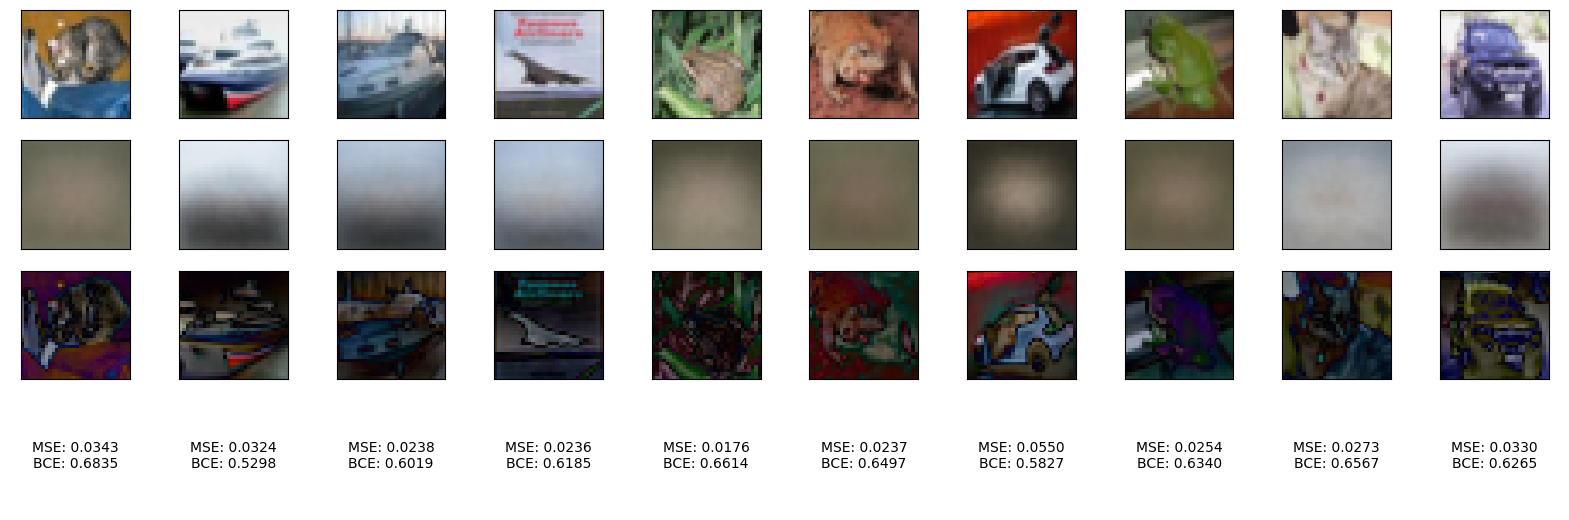

In [15]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 6 + 0.5))  # Adjust the figure size to accommodate three rows
for i in range(n):
    # Display original
    ax = plt.subplot(4, n, i + 1)
    original_img = x_test[i]
    plt.imshow(original_img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(4, n, i + 1 + n)
    reconstructed_img = x_pred[i]
    plt.imshow(reconstructed_img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display difference
    ax = plt.subplot(4, n, i + 1 + n * 2)
    difference = np.abs(original_img - reconstructed_img)
    plt.imshow(difference)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Calculate losses
    mse_loss, bce_loss = calculate_reconstruction_losses(original_img, reconstructed_img)

    # Add captions with losses
    ax = plt.subplot(4, n, i + 1 + n * 3)
    plt.axis('off')
    loss_caption = f"MSE: {mse_loss:.4f}\nBCE: {bce_loss:.4f}"
    plt.text(0.5, 0.5, loss_caption, ha='center', va='center', fontsize=10, transform=ax.transAxes)

plt.show()

**Variational Auto-Encoder (VAE) Implementation**

**Model Architecture**

In [16]:
# Hyperparameters
batch_size = 64
original_dim = 3072  # 32*32*3
latent_dim = 2
intermediate_dim = 256
epochs = 20
epsilon_std = 1.0

# Encoder network
x = Input(shape=(original_dim,), name='input')
h = Dense(intermediate_dim, activation='relu', name='encoding')(x)
z_mean = Dense(latent_dim, name='mean')(h)
z_log_var = Dense(latent_dim, name='log-variance')(h)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# Sample from the latent distribution
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder network
decoder_h = Dense(intermediate_dim, activation='relu', name='decoder_h')
decoder_mean = Dense(original_dim, activation='sigmoid', name='decoder_mean')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# VAE model
vae = Model(x, x_decoded_mean)

# Loss function: reconstruction loss + KL divergence
reconstruction_loss = binary_crossentropy(x, x_decoded_mean) * original_dim
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer=Adam())

In [17]:
vae_x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
vae_x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

**Training**

In [18]:
vae.fit(vae_x_train, vae_x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(vae_x_test, vae_x_test))

Epoch 1/20
782/782 [==============================] - 7s 6ms/step - loss: 1989.9647 - val_loss: 1972.4604
Epoch 2/20
782/782 [==============================] - 4s 5ms/step - loss: 1963.6969 - val_loss: 1964.3601
Epoch 3/20
782/782 [==============================] - 4s 5ms/step - loss: 1961.6523 - val_loss: 1968.9706
Epoch 4/20
782/782 [==============================] - 4s 5ms/step - loss: 1960.2390 - val_loss: 1960.8671
Epoch 5/20
782/782 [==============================] - 4s 5ms/step - loss: 1959.1906 - val_loss: 1966.1995
Epoch 6/20
782/782 [==============================] - 5s 6ms/step - loss: 1958.5356 - val_loss: 1961.2717
Epoch 7/20
782/782 [==============================] - 4s 5ms/step - loss: 1957.9241 - val_loss: 1960.7859
Epoch 8/20
782/782 [==============================] - 5s 6ms/step - loss: 1956.9598 - val_loss: 1959.5527
Epoch 9/20
782/782 [==============================] - 7s 9ms/step - loss: 1956.1757 - val_loss: 1957.3883
Epoch 10/20
782/782 [=========================

In [19]:
vae_x_test_pred = vae.predict(vae_x_test)

313/313 [==============================] - 1s 2ms/step


**Reconstruction**

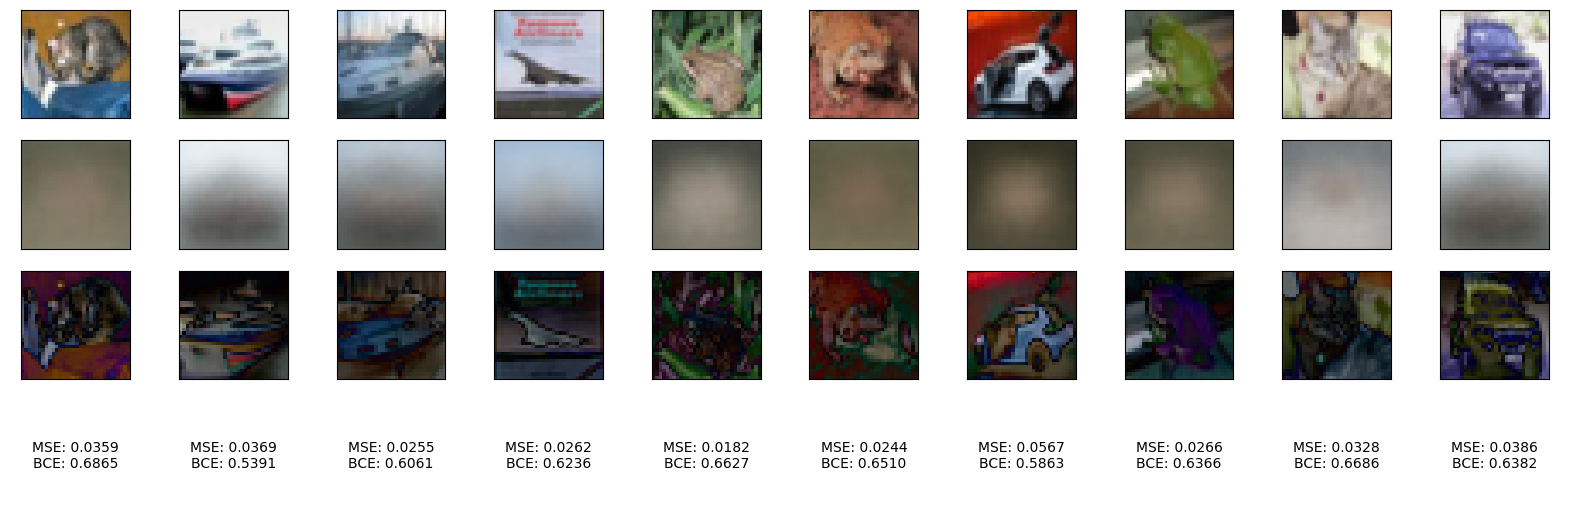

In [20]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 6 + 0.5))  # Adjust the figure size to accommodate three rows
for i in range(n):
    # Display original
    ax = plt.subplot(4, n, i + 1)
    original_img = vae_x_test[i].reshape(32,32,3)
    plt.imshow(original_img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(4, n, i + 1 + n)
    reconstructed_img = vae_x_test_pred[i].reshape(32,32,3)
    plt.imshow(reconstructed_img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display difference
    ax = plt.subplot(4, n, i + 1 + n * 2)
    difference = np.abs(original_img - reconstructed_img)
    plt.imshow(difference)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Calculate losses
    mse_loss, bce_loss = calculate_reconstruction_losses(original_img, reconstructed_img)

    # Add captions with losses
    ax = plt.subplot(4, n, i + 1 + n * 3)
    plt.axis('off')
    loss_caption = f"MSE: {mse_loss:.4f}\nBCE: {bce_loss:.4f}"
    plt.text(0.5, 0.5, loss_caption, ha='center', va='center', fontsize=10, transform=ax.transAxes)

plt.show()

**Hyperparameter Tuning**

In [21]:
latent_dims = [2,4]
intermediate_dims = [128, 256]
best_loss = float('inf')
best_parameters = {}

for latent_dim in latent_dims:
  for intermediate_dim in intermediate_dims:
    # Hyperparameters
    batch_size = 64
    original_dim = 3072  # 32*32*3
    epochs = 20
    epsilon_std = 1.0

    # Encoder network
    x = Input(shape=(original_dim,), name='input')
    h = Dense(intermediate_dim, activation='relu', name='encoding')(x)
    z_mean = Dense(latent_dim, name='mean')(h)
    z_log_var = Dense(latent_dim, name='log-variance')(h)

    # Sampling function
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    # Sample from the latent distribution
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    # Decoder network
    decoder_h = Dense(intermediate_dim, activation='relu', name='decoder_h')
    decoder_mean = Dense(original_dim, activation='sigmoid', name='decoder_mean')
    h_decoded = decoder_h(z)
    x_decoded_mean = decoder_mean(h_decoded)

    # VAE model
    vae = Model(x, x_decoded_mean)

    # Loss function: reconstruction loss + KL divergence
    reconstruction_loss = binary_crossentropy(x, x_decoded_mean) * original_dim
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer=Adam())
    vae_x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
    vae_x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
    vae.fit(vae_x_train, vae_x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(vae_x_test, vae_x_test))
    test_loss = vae.evaluate(vae_x_test, vae_x_test)
    if test_loss < best_loss:
      best_loss = test_loss
      best_parameters['latent_dim'], best_parameters['intermediate_dim'] = latent_dim, intermediate_dim
    print("="*30)

print("Best Parameters: ", best_parameters)




Epoch 1/20
782/782 [==============================] - 7s 6ms/step - loss: 1987.3776 - val_loss: 1969.4930
Epoch 2/20
782/782 [==============================] - 4s 6ms/step - loss: 1961.4567 - val_loss: 1968.1156
Epoch 3/20
782/782 [==============================] - 5s 6ms/step - loss: 1960.0438 - val_loss: 1962.4994
Epoch 4/20
782/782 [==============================] - 4s 5ms/step - loss: 1959.3633 - val_loss: 1961.5654
Epoch 5/20
782/782 [==============================] - 4s 5ms/step - loss: 1958.6329 - val_loss: 1960.3639
Epoch 6/20
782/782 [==============================] - 4s 5ms/step - loss: 1957.7874 - val_loss: 1960.1963
Epoch 7/20
782/782 [==============================] - 4s 5ms/step - loss: 1957.6783 - val_loss: 1960.1298
Epoch 8/20
782/782 [==============================] - 5s 6ms/step - loss: 1957.1985 - val_loss: 1960.6230
Epoch 9/20
782/782 [==============================] - 7s 9ms/step - loss: 1956.8536 - val_loss: 1958.9974
Epoch 10/20
782/782 [=========================

In [22]:
 latent_dim, intermediate_dim = best_parameters['latent_dim'], best_parameters['intermediate_dim']

**Model Architecture**

In [34]:
# Hyperparameters
batch_size = 64
original_dim = 3072  # 32*32*3
epochs = 20
epsilon_std = 1.0

# Encoder network
x = Input(shape=(original_dim,), name='input')
h = Dense(intermediate_dim, activation='relu', name='encoding')(x)
z_mean = Dense(latent_dim, name='mean')(h)
z_log_var = Dense(latent_dim, name='log-variance')(h)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# Sample from the latent distribution
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder network
decoder_h = Dense(intermediate_dim, activation='relu', name='decoder_h')
decoder_mean = Dense(original_dim, activation='sigmoid', name='decoder_mean')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# VAE model
vae_final = Model(x, x_decoded_mean)

# VAE Encoder model
vae_encoder_final = Model(x, z_mean)

# Loss function: reconstruction loss + KL divergence
reconstruction_loss = binary_crossentropy(x, x_decoded_mean) * original_dim
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae_final.add_loss(vae_loss)
vae_final.compile(optimizer=Adam())


In [35]:
vae_x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
vae_x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


**Training**

In [36]:
vae_final.fit(vae_x_train, vae_x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(vae_x_test, vae_x_test))

Epoch 1/20
782/782 [==============================] - 6s 6ms/step - loss: 1952.2175 - val_loss: 1925.9041
Epoch 2/20
782/782 [==============================] - 4s 5ms/step - loss: 1921.6763 - val_loss: 1921.8804
Epoch 3/20
782/782 [==============================] - 5s 6ms/step - loss: 1918.5260 - val_loss: 1920.6221
Epoch 4/20
782/782 [==============================] - 4s 5ms/step - loss: 1916.9124 - val_loss: 1924.2456
Epoch 5/20
782/782 [==============================] - 4s 5ms/step - loss: 1915.7371 - val_loss: 1917.2749
Epoch 6/20
782/782 [==============================] - 5s 6ms/step - loss: 1914.6173 - val_loss: 1915.7374
Epoch 7/20
782/782 [==============================] - 4s 5ms/step - loss: 1913.8292 - val_loss: 1915.9448
Epoch 8/20
782/782 [==============================] - 4s 5ms/step - loss: 1913.5831 - val_loss: 1915.3951
Epoch 9/20
782/782 [==============================] - 4s 6ms/step - loss: 1912.7476 - val_loss: 1914.5625
Epoch 10/20
782/782 [=========================

In [37]:
vae_x_test_pred = vae_final.predict(vae_x_test)

313/313 [==============================] - 1s 2ms/step


**Reconstruction**

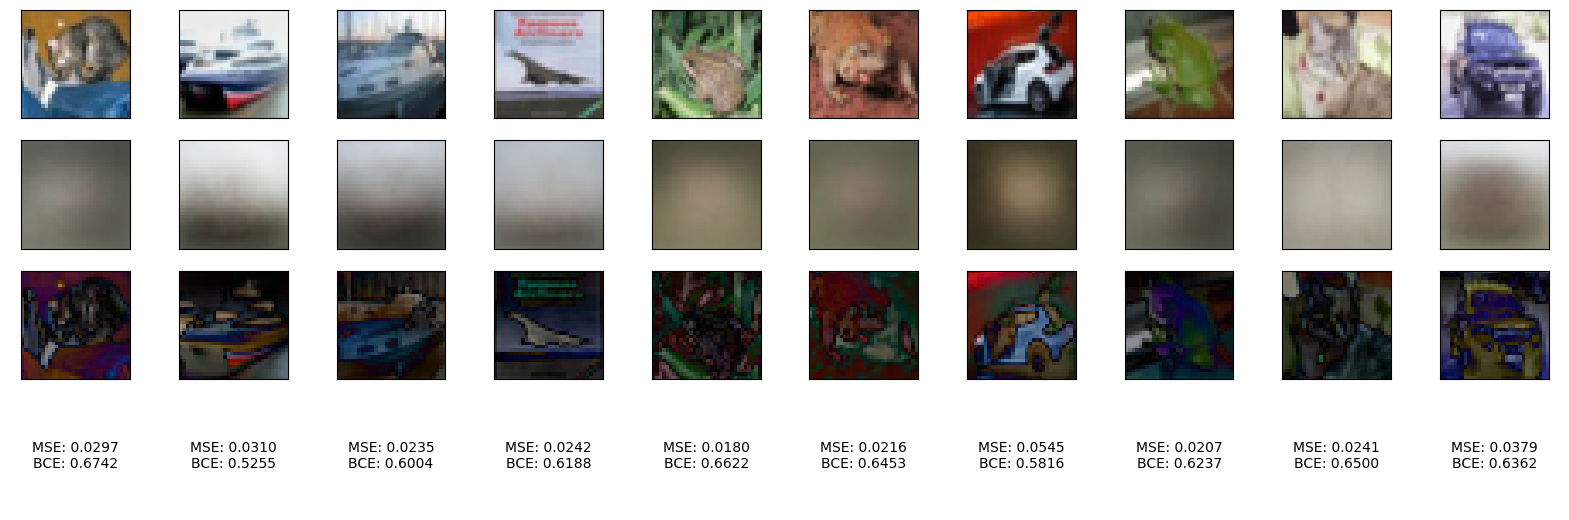

In [38]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 6 + 0.5))  # Adjust the figure size to accommodate three rows
for i in range(n):
    # Display original
    ax = plt.subplot(4, n, i + 1)
    original_img = vae_x_test[i].reshape(32,32,3)
    plt.imshow(original_img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(4, n, i + 1 + n)
    reconstructed_img = vae_x_test_pred[i].reshape(32,32,3)
    plt.imshow(reconstructed_img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display difference
    ax = plt.subplot(4, n, i + 1 + n * 2)
    difference = np.abs(original_img - reconstructed_img)
    plt.imshow(difference)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Calculate losses
    mse_loss, bce_loss = calculate_reconstruction_losses(original_img, reconstructed_img)

    # Add captions with losses
    ax = plt.subplot(4, n, i + 1 + n * 3)
    plt.axis('off')
    loss_caption = f"MSE: {mse_loss:.4f}\nBCE: {bce_loss:.4f}"
    plt.text(0.5, 0.5, loss_caption, ha='center', va='center', fontsize=10, transform=ax.transAxes)

plt.show()

**Analysis and Comparison**

**Reconstruction Quality**

**Reconstruction Quality - Auto Encoder**

In [39]:
x_pred = autoencoder_final.predict(x_test)

313/313 [==============================] - 1s 3ms/step


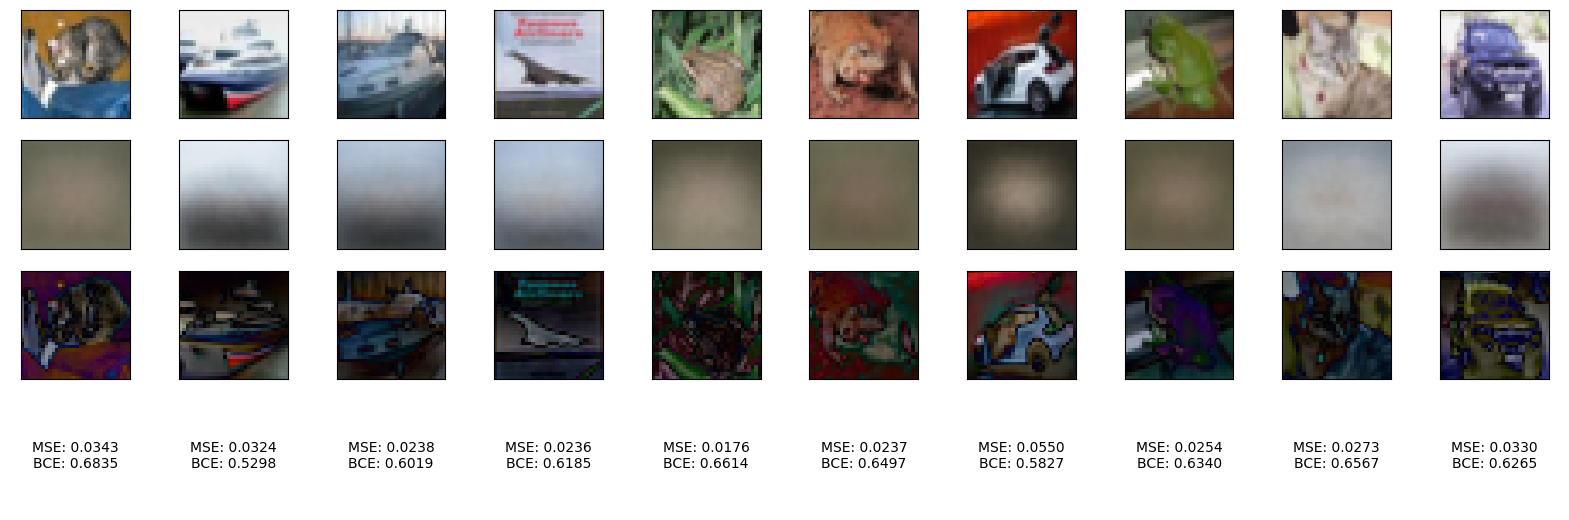

In [40]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 6 + 0.5))  # Adjust the figure size to accommodate three rows
for i in range(n):
    # Display original
    ax = plt.subplot(4, n, i + 1)
    original_img = x_test[i]
    plt.imshow(original_img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(4, n, i + 1 + n)
    reconstructed_img = x_pred[i]
    plt.imshow(reconstructed_img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display difference
    ax = plt.subplot(4, n, i + 1 + n * 2)
    difference = np.abs(original_img - reconstructed_img)
    plt.imshow(difference)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Calculate losses
    mse_loss, bce_loss = calculate_reconstruction_losses(original_img, reconstructed_img)

    # Add captions with losses
    ax = plt.subplot(4, n, i + 1 + n * 3)
    plt.axis('off')
    loss_caption = f"MSE: {mse_loss:.4f}\nBCE: {bce_loss:.4f}"
    plt.text(0.5, 0.5, loss_caption, ha='center', va='center', fontsize=10, transform=ax.transAxes)

plt.show()

****Reconstruction Quality - Variational Auto Encoder****

In [41]:
vae_x_test_pred = vae_final.predict(vae_x_test)

313/313 [==============================] - 1s 2ms/step


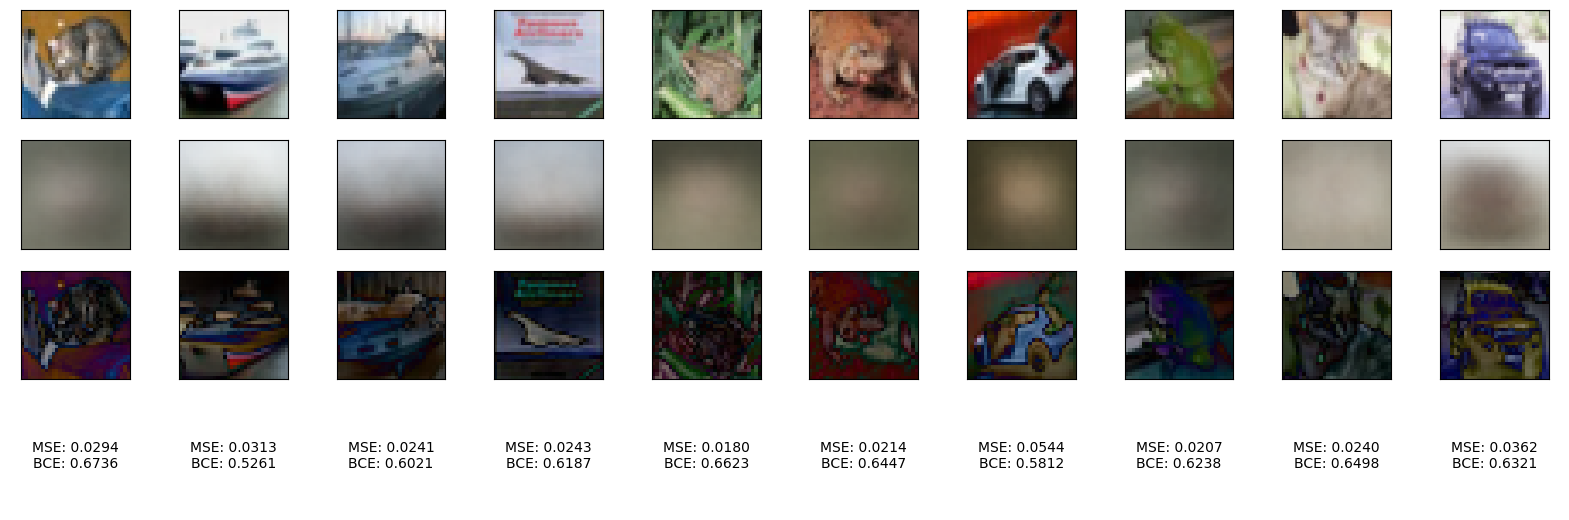

In [42]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 6 + 0.5))  # Adjust the figure size to accommodate three rows
for i in range(n):
    # Display original
    ax = plt.subplot(4, n, i + 1)
    original_img = vae_x_test[i].reshape(32,32,3)
    plt.imshow(original_img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(4, n, i + 1 + n)
    reconstructed_img = vae_x_test_pred[i].reshape(32,32,3)
    plt.imshow(reconstructed_img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display difference
    ax = plt.subplot(4, n, i + 1 + n * 2)
    difference = np.abs(original_img - reconstructed_img)
    plt.imshow(difference)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Calculate losses
    mse_loss, bce_loss = calculate_reconstruction_losses(original_img, reconstructed_img)

    # Add captions with losses
    ax = plt.subplot(4, n, i + 1 + n * 3)
    plt.axis('off')
    loss_caption = f"MSE: {mse_loss:.4f}\nBCE: {bce_loss:.4f}"
    plt.text(0.5, 0.5, loss_caption, ha='center', va='center', fontsize=10, transform=ax.transAxes)

plt.show()

**Latent Space Analysis**

**AE**

157/157 [==============================] - 0s 2ms/step


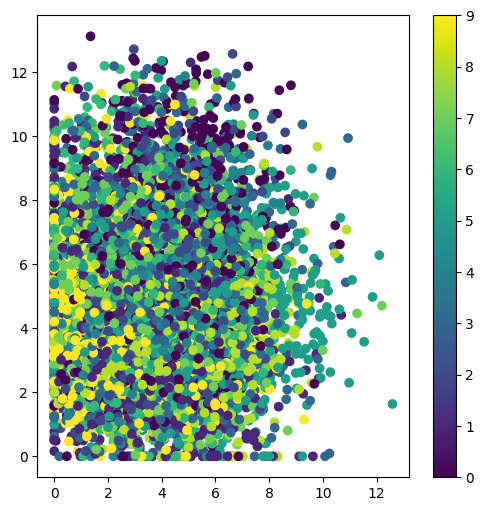

In [47]:
x_test_encoded = autoencoder_encoder_final.predict(x_test, batch_size=batch_size)

plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 4], x_test_encoded[:, 11], c=y_test)
plt.colorbar()
plt.show()

**VAE**

157/157 [==============================] - 0s 2ms/step


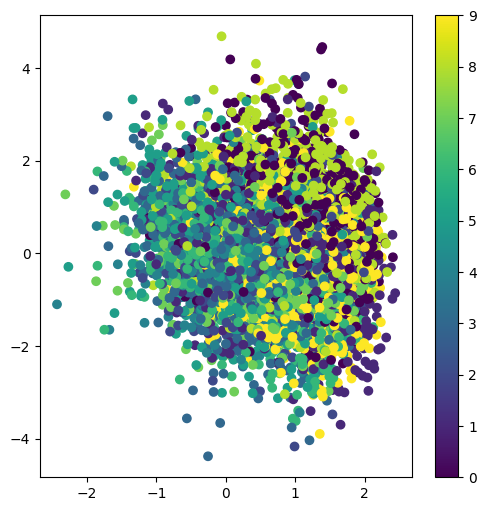

In [44]:
x_test_encoded = vae_encoder_final.predict(vae_x_test, batch_size=batch_size)

plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

**Performance Discussion**

**AE Model reconstructed Images are slightly better than VAE Model reconstructed Images**